In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Data Processing

In [ ]:
# Load the dataset and set datetime index
df = pd.read_csv('../data/merged_cleaned.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.set_index('Datetime', inplace=True)

# Clean data: Remove commas and convert to float
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

In [22]:
df

,Computer - kWatts,Plug Load (kWatts),Air Conditioner-kWatts,light + fan - kWatts,Total Energy,CO2_Indoor [ppm],Temperature_Indoor [°C],Pressure_Indoor [mbar],Relative Humidity_Indoor [%RH],Dewpoint Temperature_Indoor [°C td],Air Density_Indoor [g/m³],CO2_Outdoor [ppm],Temperature_Outdoor [°C],Pressure_Outdoor [mbar],Relative Humidity_Outdoor [%RH],Dewpoint Temperature_Outdoor [°C td],Air Density_Outdoor [g/m³]
Datetime,,,,,,,,,,,,,,,,,
2023-02-13 12:00:00,0.0000,0.0005,0.2035,0.0000,0.2040,538.0,26.1,1007.0,37.8,10.6,9.2,389.940639,21.831818,1008.0,45.813636,9.068636,8.617727
2023-02-13 12:15:00,0.0000,0.0042,0.0643,0.0000,0.0685,559.0,25.6,1007.0,38.6,10.5,9.2,390.054546,21.819005,1008.0,45.911765,9.085973,8.628507
2023-02-13 12:30:00,0.0000,0.0000,0.0507,0.0912,0.1419,548.0,25.8,1006.0,37.6,10.3,9.1,390.149321,21.806757,1008.0,46.011261,9.104054,8.640090
2023-02-13 12:45:00,0.0000,0.0000,0.0509,0.0914,0.1423,529.0,26.0,1006.0,36.8,10.1,8.9,390.247748,21.795964,1008.0,46.112556,9.123767,8.652915
2023-02-13 13:00:00,0.0000,0.0000,0.0513,0.0933,0.1446,529.0,26.0,1006.0,36.3,9.9,8.8,390.349776,21.786161,1008.0,46.227232,9.147321,8.668304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01 23:00:00,0.0207,0.0000,0.0000,0.0000,0.0207,338.0,20.9,1010.0,70.6,15.4,12.9,250.000000,18.200000,1010.0,82.000000,15.100000,12.800000
2024-01-01 23:15:00,0.0205,0.0000,0.0000,0.0000,0.0205,346.0,20.9,1010.0,70.6,15.4,12.9,255.000000,18.100000,1010.0,82.300000,15.000000,12.700000
2024-01-01 23:30:00,0.0206,0.0000,0.0000,0.0000,0.0206,346.0,20.9,1010.0,70.6,15.4,12.9,256.000000,18.100000,1010.0,82.600000,15.100000,12.800000


In [23]:
# Define function to classify missing times
def classify_missing_times(freq='15T'):
    single_entries = []
    time_ranges = []
    start_time = None
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    missing_times = full_range.difference(df.index.dropna()).to_list()

    for i, time in enumerate(missing_times):
        if start_time is None:
            start_time = time
        if i < len(missing_times) - 1 and missing_times[i + 1] == time + pd.Timedelta(freq):
            continue
        else:
            if start_time == time:
                single_entries.append(start_time)
            else:
                time_ranges.append((start_time, time))
            start_time = None

    return single_entries, time_ranges

In [24]:
# Identify single and range missing times
single_entries, time_ranges = classify_missing_times()

In [25]:
single_entries

[Timestamp('2023-09-05 12:30:00'),
 Timestamp('2023-09-05 16:00:00'),
 Timestamp('2023-09-06 18:45:00'),
 Timestamp('2023-09-07 16:30:00'),
 Timestamp('2023-09-08 16:00:00'),
 Timestamp('2023-09-08 16:45:00'),
 Timestamp('2023-09-08 17:15:00'),
 Timestamp('2023-09-09 17:45:00'),
 Timestamp('2023-09-09 18:15:00'),
 Timestamp('2023-09-10 15:15:00'),
 Timestamp('2023-09-10 18:00:00'),
 Timestamp('2023-09-11 10:15:00'),
 Timestamp('2023-09-11 12:00:00'),
 Timestamp('2023-09-11 18:00:00')]

In [26]:
# Fill single missing time entries by interpolation
for single_time in single_entries:
    if (single_time - pd.Timedelta(minutes=15)) in df.index and (single_time + pd.Timedelta(minutes=15)) in df.index:
        df.loc[single_time] = pd.Series([None], dtype='float64')

df.interpolate(method='linear', inplace=True)

df = df.sort_values(by='Datetime')

In [27]:
df

,Computer - kWatts,Plug Load (kWatts),Air Conditioner-kWatts,light + fan - kWatts,Total Energy,CO2_Indoor [ppm],Temperature_Indoor [°C],Pressure_Indoor [mbar],Relative Humidity_Indoor [%RH],Dewpoint Temperature_Indoor [°C td],Air Density_Indoor [g/m³],CO2_Outdoor [ppm],Temperature_Outdoor [°C],Pressure_Outdoor [mbar],Relative Humidity_Outdoor [%RH],Dewpoint Temperature_Outdoor [°C td],Air Density_Outdoor [g/m³]
Datetime,,,,,,,,,,,,,,,,,
2023-02-13 12:00:00,0.0000,0.0005,0.2035,0.0000,0.2040,538.0,26.1,1007.0,37.8,10.6,9.2,389.940639,21.831818,1008.0,45.813636,9.068636,8.617727
2023-02-13 12:15:00,0.0000,0.0042,0.0643,0.0000,0.0685,559.0,25.6,1007.0,38.6,10.5,9.2,390.054546,21.819005,1008.0,45.911765,9.085973,8.628507
2023-02-13 12:30:00,0.0000,0.0000,0.0507,0.0912,0.1419,548.0,25.8,1006.0,37.6,10.3,9.1,390.149321,21.806757,1008.0,46.011261,9.104054,8.640090
2023-02-13 12:45:00,0.0000,0.0000,0.0509,0.0914,0.1423,529.0,26.0,1006.0,36.8,10.1,8.9,390.247748,21.795964,1008.0,46.112556,9.123767,8.652915
2023-02-13 13:00:00,0.0000,0.0000,0.0513,0.0933,0.1446,529.0,26.0,1006.0,36.3,9.9,8.8,390.349776,21.786161,1008.0,46.227232,9.147321,8.668304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01 23:00:00,0.0207,0.0000,0.0000,0.0000,0.0207,338.0,20.9,1010.0,70.6,15.4,12.9,250.000000,18.200000,1010.0,82.000000,15.100000,12.800000
2024-01-01 23:15:00,0.0205,0.0000,0.0000,0.0000,0.0205,346.0,20.9,1010.0,70.6,15.4,12.9,255.000000,18.100000,1010.0,82.300000,15.000000,12.700000
2024-01-01 23:30:00,0.0206,0.0000,0.0000,0.0000,0.0206,346.0,20.9,1010.0,70.6,15.4,12.9,256.000000,18.100000,1010.0,82.600000,15.100000,12.800000


In [28]:
# Print time ranges and count missing entries in each
print("Continuous Time Ranges and Count of Missing Entries:")
for start, end in time_ranges:
    count = (end - start) // pd.Timedelta('15T') + 1
    print(f"From {start} to {end}: {count} missing entries")

Continuous Time Ranges and Count of Missing Entries:
From 2023-02-13 19:30:00 to 2023-02-13 23:45:00: 18 missing entries
From 2023-03-17 03:00:00 to 2023-03-17 04:30:00: 7 missing entries
From 2023-06-09 21:00:00 to 2023-06-09 21:45:00: 4 missing entries
From 2023-09-05 15:00:00 to 2023-09-05 15:15:00: 2 missing entries
From 2023-09-05 17:30:00 to 2023-09-06 09:45:00: 66 missing entries
From 2023-09-06 12:15:00 to 2023-09-06 13:00:00: 4 missing entries
From 2023-09-06 13:30:00 to 2023-09-06 13:45:00: 2 missing entries
From 2023-09-06 15:15:00 to 2023-09-06 15:30:00: 2 missing entries
From 2023-09-06 18:00:00 to 2023-09-06 18:15:00: 2 missing entries
From 2023-09-06 19:15:00 to 2023-09-07 11:00:00: 64 missing entries
From 2023-09-07 11:30:00 to 2023-09-07 11:45:00: 2 missing entries
From 2023-09-07 12:15:00 to 2023-09-07 12:45:00: 3 missing entries
From 2023-09-07 13:15:00 to 2023-09-07 15:45:00: 11 missing entries
From 2023-09-07 17:00:00 to 2023-09-07 17:15:00: 2 missing entries
From 

## EDA

In [29]:
# EDA
print("Data Shape:", df.shape)
print("-------------------------------------------------------------------")
print(df.dtypes)
print("-------------------------------------------------------------------")
print(df.isnull().sum())
print("-------------------------------------------------------------------")
print(df.describe())

Data Shape: (30452, 17)
-------------------------------------------------------------------
Computer - kWatts                       float64
Plug Load (kWatts)                      float64
Air Conditioner-kWatts                  float64
light + fan - kWatts                    float64
Total Energy                            float64
CO2_Indoor [ppm]                        float64
Temperature_Indoor [°C]                 float64
Pressure_Indoor [mbar]                  float64
Relative Humidity_Indoor [%RH]          float64
Dewpoint Temperature_Indoor [°C td]     float64
Air Density_Indoor [g/m³]               float64
CO2_Outdoor [ppm]                       float64
Temperature_Outdoor [°C]                float64
Pressure_Outdoor [mbar]                 float64
Relative Humidity_Outdoor [%RH]         float64
Dewpoint Temperature_Outdoor [°C td]    float64
Air Density_Outdoor [g/m³]              float64
dtype: object
-------------------------------------------------------------------
Computer -

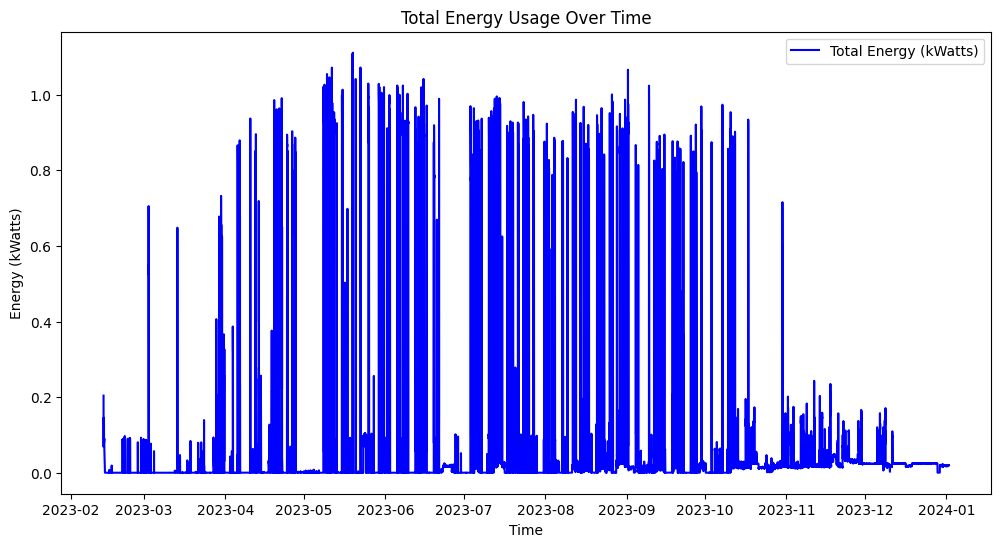

In [30]:
# Plotting Time Series Data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Total Energy'], label='Total Energy (kWatts)', color='blue')
plt.title('Total Energy Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Energy (kWatts)')
plt.legend()
plt.show()

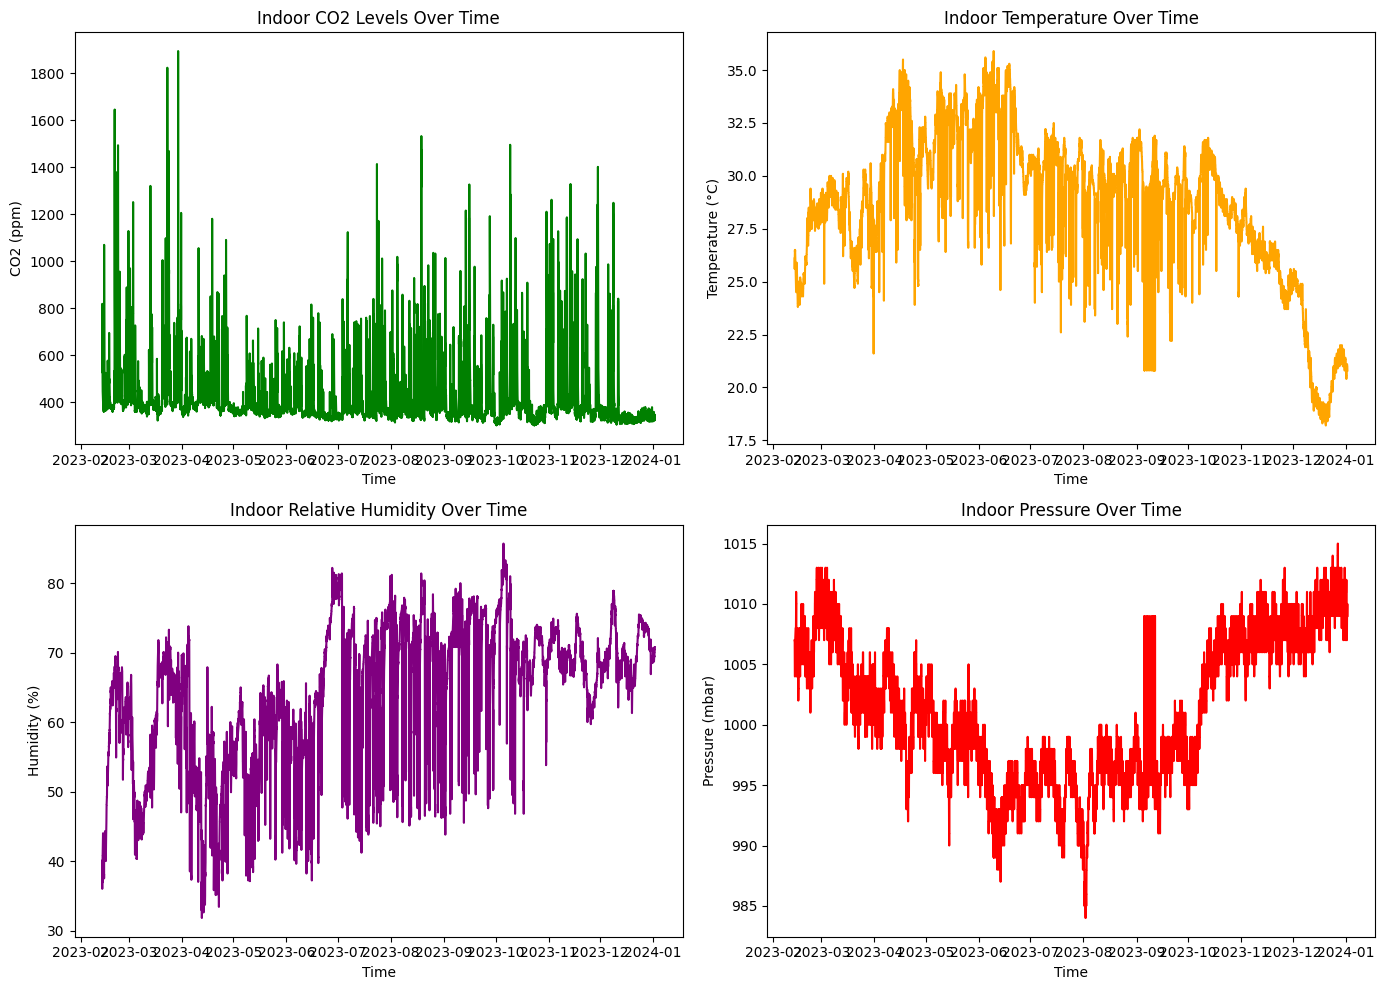

In [31]:
# Subplots for Environmental Data
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(df.index, df['CO2_Indoor [ppm]'], color='green')
axs[0, 0].set_title('Indoor CO2 Levels Over Time')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('CO2 (ppm)')

axs[0, 1].plot(df.index, df['Temperature_Indoor [°C]'], color='orange')
axs[0, 1].set_title('Indoor Temperature Over Time')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Temperature (°C)')

axs[1, 0].plot(df.index, df['Relative Humidity_Indoor [%RH]'], color='purple')
axs[1, 0].set_title('Indoor Relative Humidity Over Time')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Humidity (%)')

axs[1, 1].plot(df.index, df['Pressure_Indoor [mbar]'], color='red')
axs[1, 1].set_title('Indoor Pressure Over Time')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Pressure (mbar)')

plt.tight_layout()
plt.show()

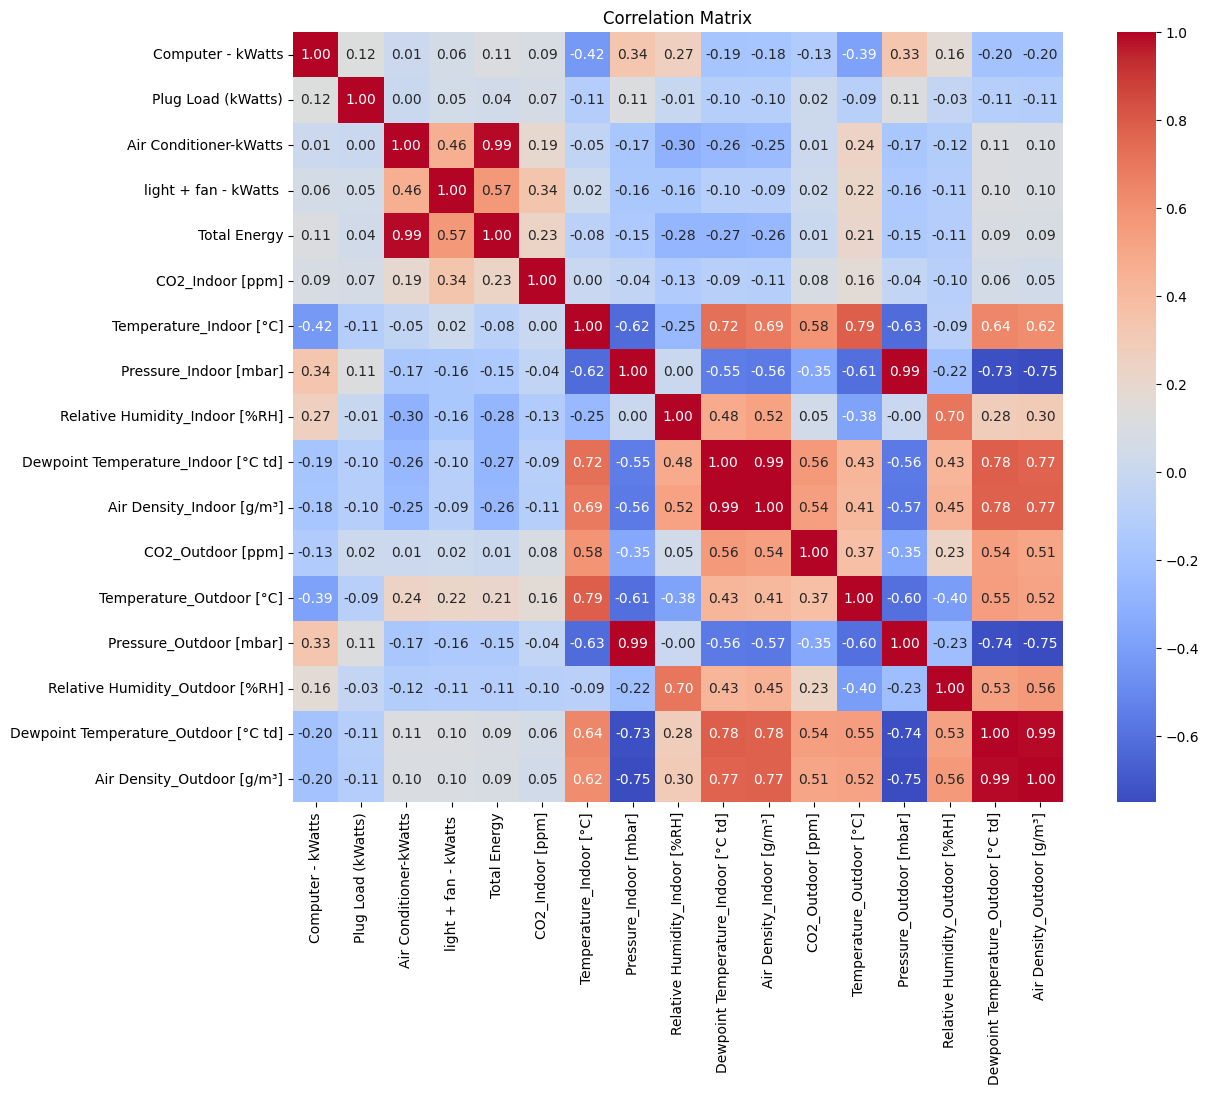

In [32]:
# Correlation Analysis
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

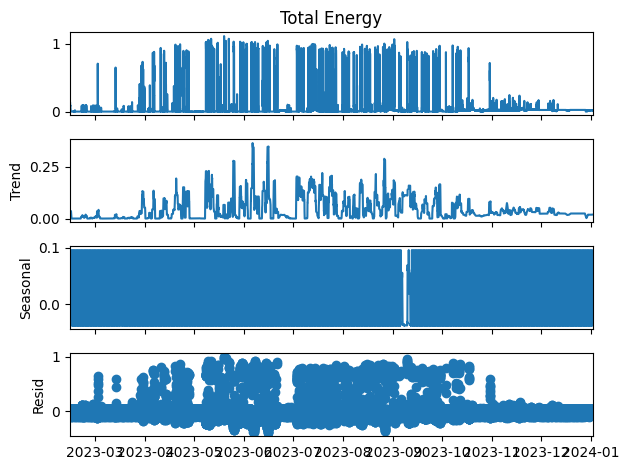

In [33]:
# Seasonal Decomposition
result = seasonal_decompose(df['Total Energy'], model='additive', period=96)
result.plot()
plt.show()

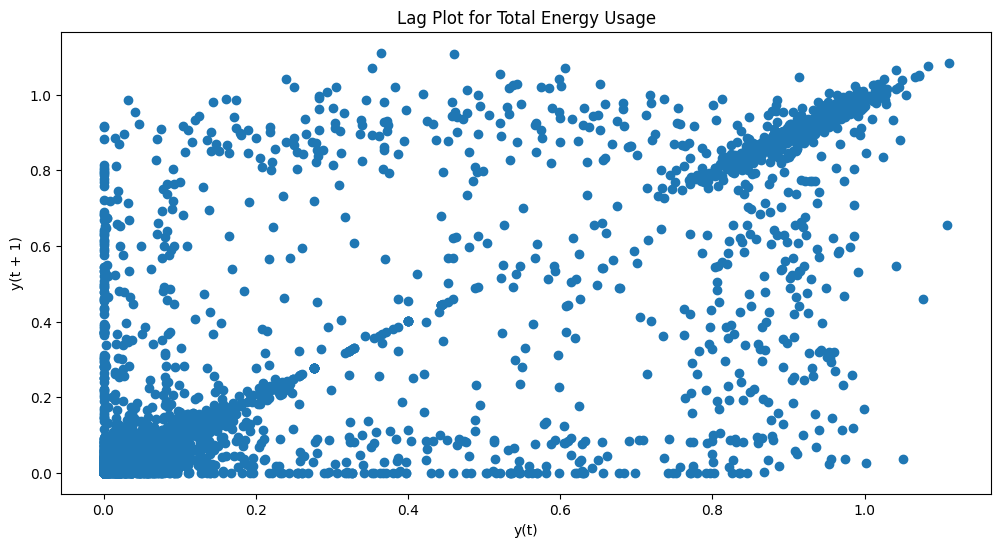

In [34]:
# Lag Plot for Total Energy
plt.figure(figsize=(12, 6))
pd.plotting.lag_plot(df['Total Energy'])
plt.title('Lag Plot for Total Energy Usage')
plt.show()

## Export Processed data

In [ ]:
df.to_csv('../data/processed_data.csv')